Imports & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Set plotting style
sns.set(style="whitegrid")

# Load dataset
df = pd.read_csv("data/togo-dapaong_qc.csv", parse_dates=["Timestamp"])
df.head()


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 00:01:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
1,2021-10-25 00:02:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2,2021-10-25 00:03:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
3,2021-10-25 00:04:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
4,2021-10-25 00:05:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN


Summary Statistics & Missing Values

In [2]:
df.describe()

# Missing value count
missing = df.isna().sum()
missing_percent = (missing / len(df)) * 100
missing_report = pd.DataFrame({"Missing": missing, "Percent": missing_percent})
missing_report[missing_report["Percent"] > 5]


,Missing,Percent
Comments,525600,100.0


Outlier Detection & Cleaning

In [3]:
cols_to_check = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]

# Compute Z-scores and filter outliers (|Z| > 3)
z_scores = df[cols_to_check].apply(zscore)
outliers = (np.abs(z_scores) > 3)
outlier_counts = outliers.sum()
print("Outlier counts:\n", outlier_counts)

# Drop or impute missing values
df_cleaned = df.copy()
for col in cols_to_check:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

# Save cleaned data
df_cleaned.to_csv("data/togo_clean.csv", index=False)


Outlier counts:
 GHI        305
DNI       1062
DHI       3415
ModA       137
ModB       206
WS        3510
WSgust    3915
dtype: int64


Time Series Analysis

<Figure size 1400x500 with 0 Axes>

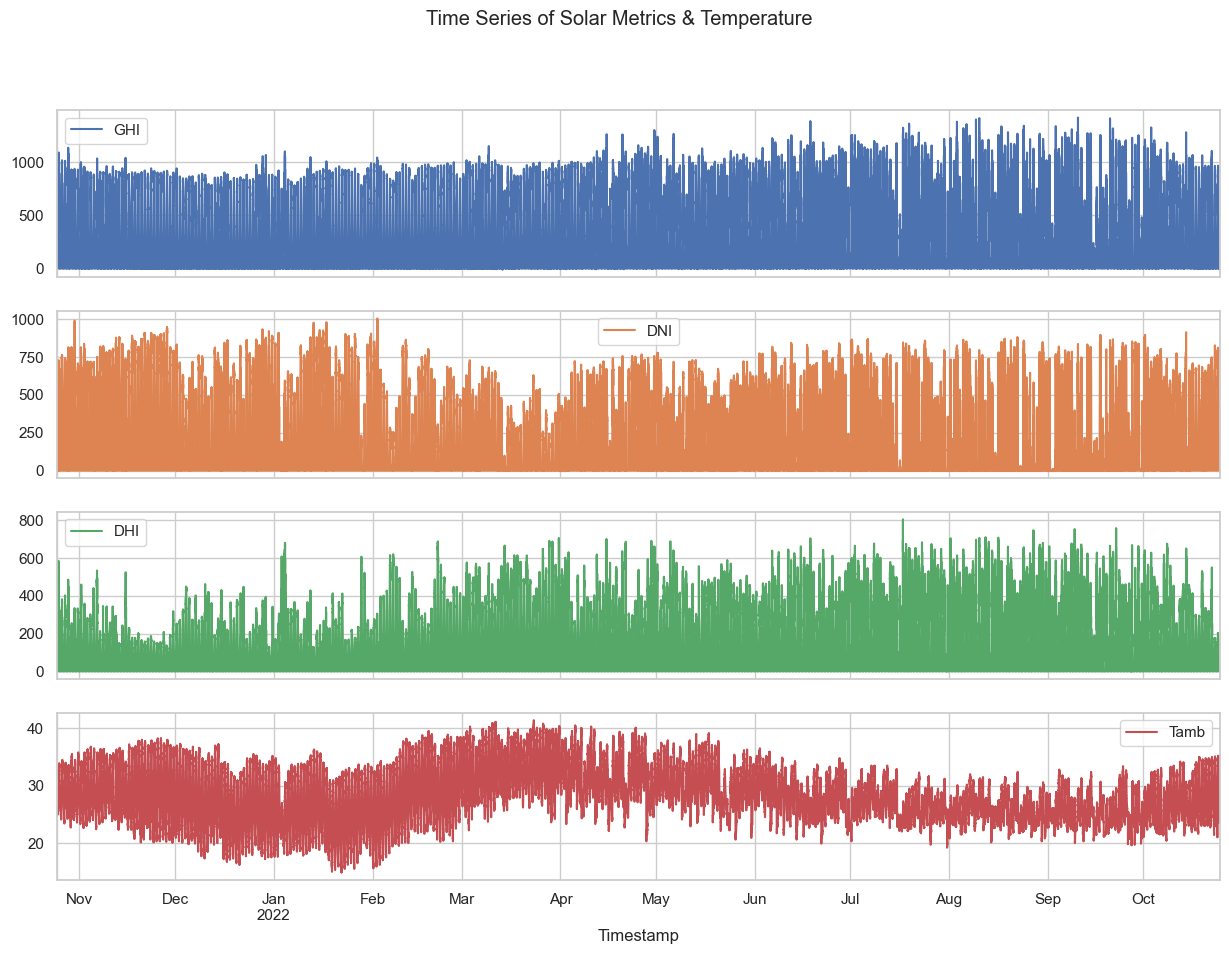

In [4]:
plt.figure(figsize=(14, 5))
df_cleaned.set_index("Timestamp")[["GHI", "DNI", "DHI", "Tamb"]].plot(subplots=True, figsize=(15, 10))
plt.suptitle("Time Series of Solar Metrics & Temperature")
plt.show()


 Cleaning Impact on ModA & ModB

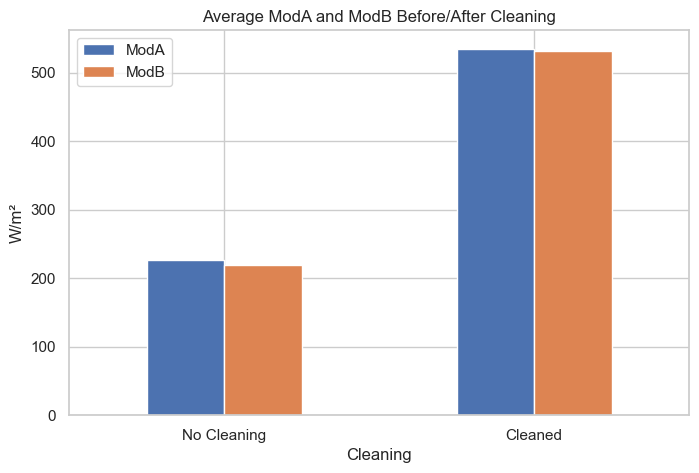

In [5]:
# Average ModA and ModB by Cleaning status
cleaning_group = df_cleaned.groupby("Cleaning")[["ModA", "ModB"]].mean().reset_index()

cleaning_group.plot(x="Cleaning", kind="bar", figsize=(8,5), title="Average ModA and ModB Before/After Cleaning")
plt.ylabel("W/m²")
plt.xticks(ticks=[0, 1], labels=["No Cleaning", "Cleaned"], rotation=0)
plt.show()


Correlation & Relationships

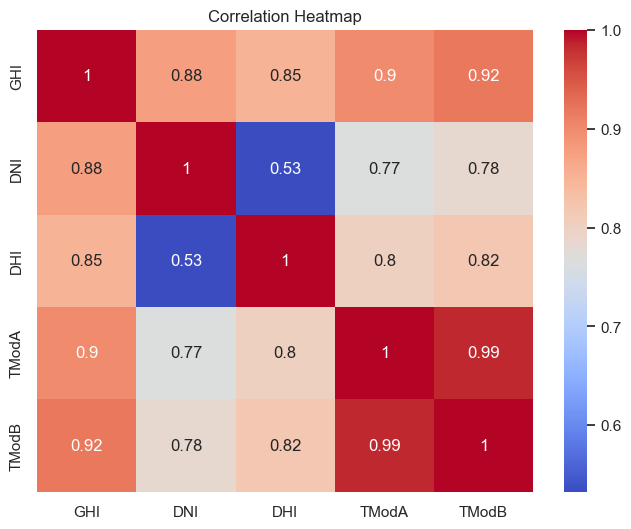

In [6]:
corr_cols = ["GHI", "DNI", "DHI", "TModA", "TModB"]
plt.figure(figsize=(8, 6))
sns.heatmap(df_cleaned[corr_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


Scatter Plots

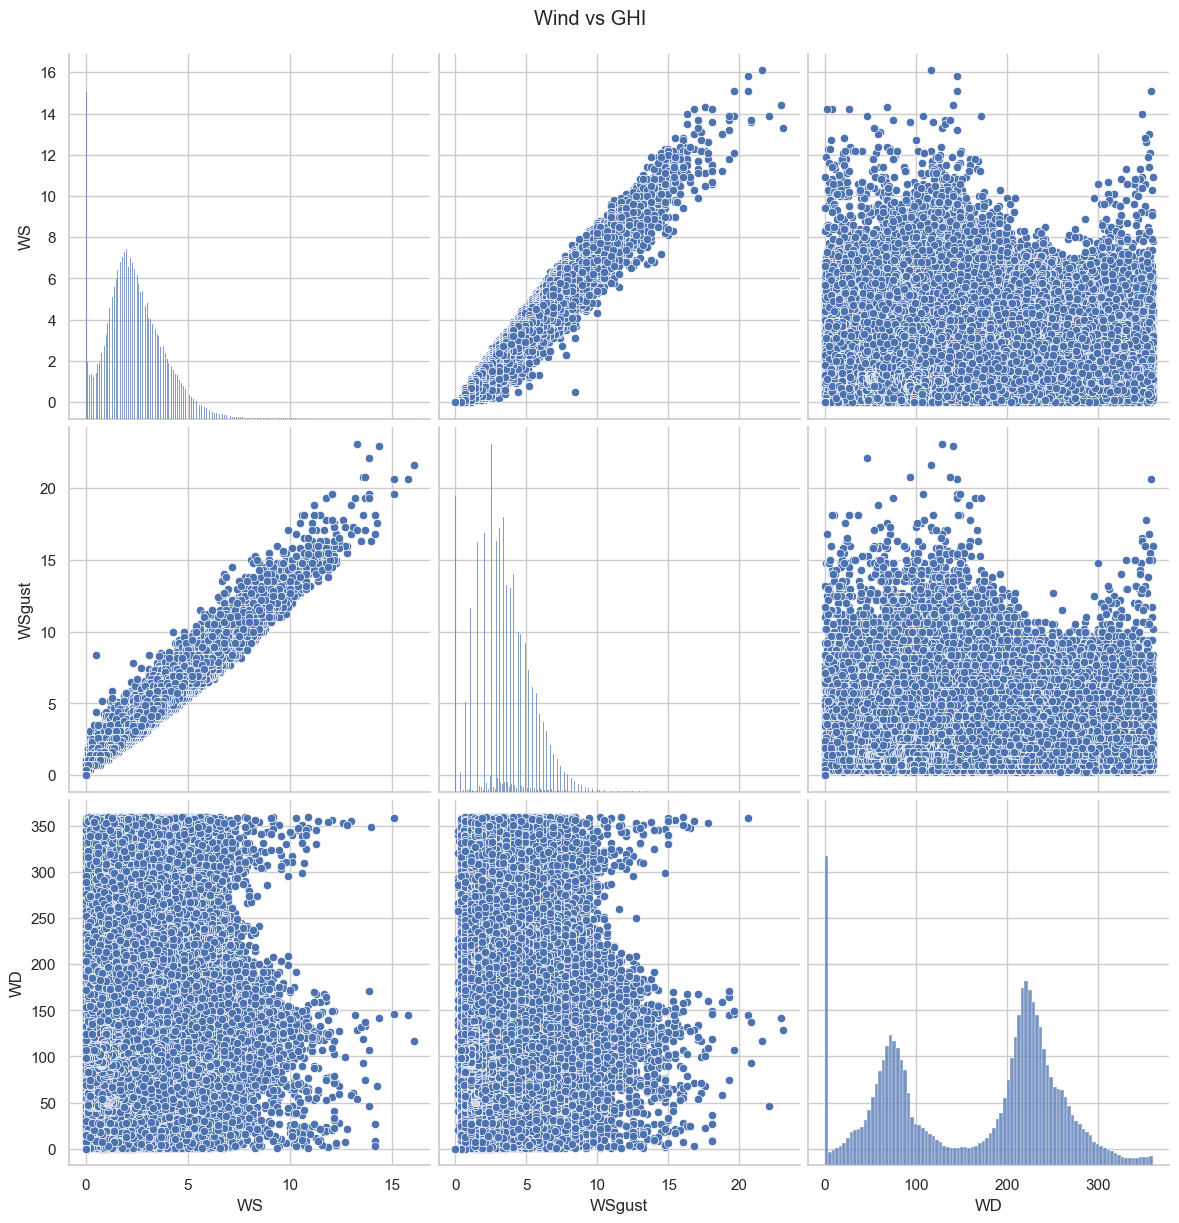

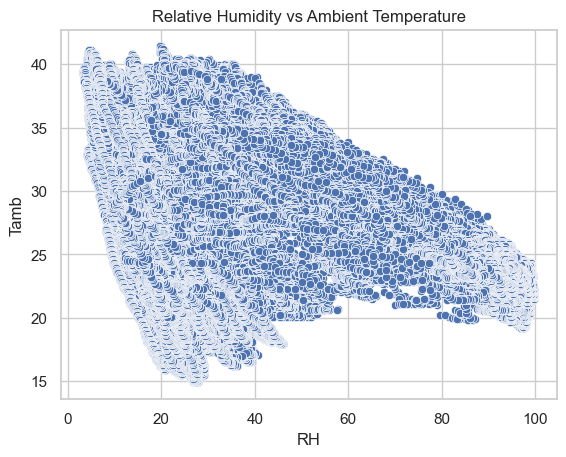

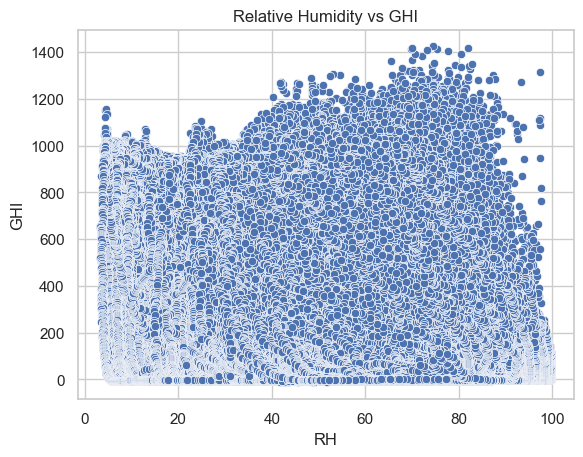

In [7]:
# WS, WSgust, WD vs GHI
sns.pairplot(df_cleaned, vars=["WS", "WSgust", "WD"], y_vars=["GHI"], height=4)
plt.suptitle("Wind vs GHI", y=1.02)
plt.show()

# RH vs Tamb and GHI
sns.scatterplot(data=df_cleaned, x="RH", y="Tamb")
plt.title("Relative Humidity vs Ambient Temperature")
plt.show()

sns.scatterplot(data=df_cleaned, x="RH", y="GHI")
plt.title("Relative Humidity vs GHI")
plt.show()


Wind & Distribution

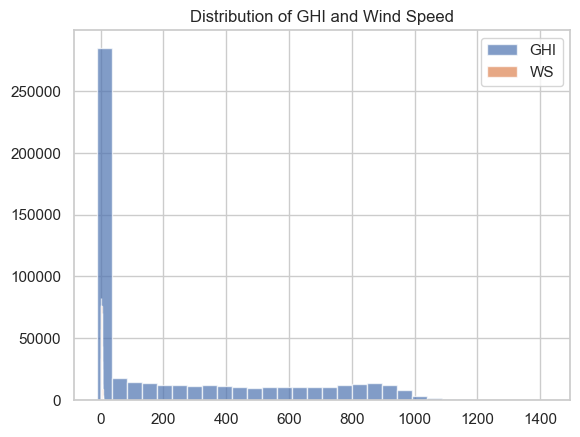

In [8]:
# Histogram of GHI and WS
df_cleaned["GHI"].hist(bins=30, alpha=0.7, label="GHI")
df_cleaned["WS"].hist(bins=30, alpha=0.7, label="WS")
plt.legend()
plt.title("Distribution of GHI and Wind Speed")
plt.show()


Temperature & RH

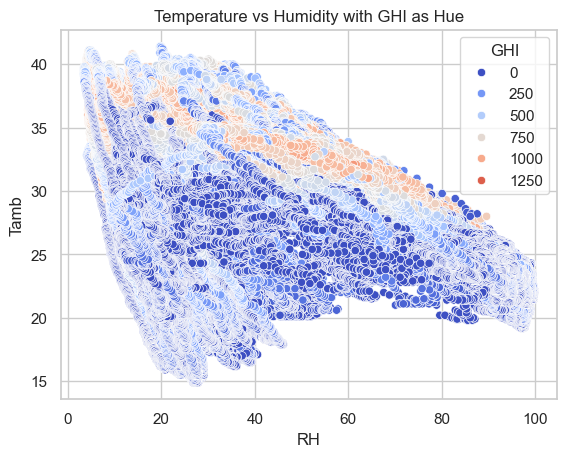

In [9]:
sns.scatterplot(data=df_cleaned, x="RH", y="Tamb", hue="GHI", palette="coolwarm")
plt.title("Temperature vs Humidity with GHI as Hue")
plt.show()


Bubble Chart: GHI vs Tamb (bubble = RH)

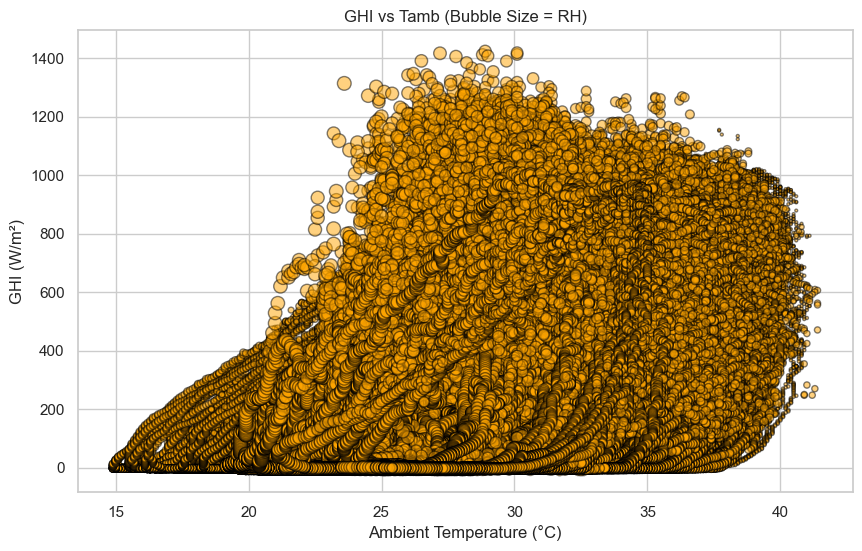

In [10]:
plt.figure(figsize=(10,6))
plt.scatter(df_cleaned["Tamb"], df_cleaned["GHI"], s=df_cleaned["RH"], alpha=0.5, c="orange", edgecolors="black")
plt.xlabel("Ambient Temperature (°C)")
plt.ylabel("GHI (W/m²)")
plt.title("GHI vs Tamb (Bubble Size = RH)")
plt.grid(True)
plt.show()
